In [172]:
!pip install optuna rdkit_pypi deepchem transformers matplotlib tqdm hmmlearn xgboost

In [173]:
import os
from typing import List
import random
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import rdkit.Chem.Descriptors
from hmmlearn.hmm import MultinomialHMM
from hmmlearn.hmm import CategoricalHMM
import xgboost

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Lipinski,Descriptors
import functools

In [174]:
# Create a new directory named 'new_directory'
!mkdir -p datasets

# Move the file 'file-cFr6VmYXiISRDMrj92GFH55R' into 'new_directory'


In [175]:
!mv /content/dataset2.csv datasets/

mv: cannot stat '/content/dataset2.csv': No such file or directory


In [176]:
dataset_path = '/content/datasets'
files = [i for i in os.listdir(dataset_path) if i.endswith('csv')]

all_smiles = set()

for file in files:
    df = pd.read_csv(os.path.join(dataset_path, file))
    all_smiles.update(df.smiles.dropna())

all_smiles = set(smile for smile in all_smiles)
print(f"total of {len(all_smiles)} smiles")
print("Sample smiles:")
for count, smile in enumerate(all_smiles):
    print(smile)
    if count > 10:
        break


total of 3082 smiles
Sample smiles:
O=C(C[n+]1ccn(CC(OCc2ccc(Cl)cc2Cl)c2ccc(Cl)cc2Cl)c1)c1ccc(F)cc1
O=C1NCN(c2ccccc2)C12CCN(CCCC(c1ccc(F)cc1)c1ccc(F)cc1)CC2
CCC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2
OCCOCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
CCN(CC)CCNC(=O)COc1ccc(OC)cc1
Cc1ccccc1OCC(O)CNCCOc1ccc(C(N)=O)cc1
C[N+](C)(C)CCOC(=O)CCC(=O)OCC[N+](C)(C)C
O=C(CCCN1CCC(O)(c2ccc(Cl)c(C(F)(F)F)c2)CC1)c1ccc(F)cc1
Nc1nc(O)c2ncn(COC(CO)CO)c2n1
CC(COc1ccccc1)N(CCCl)Cc1ccccc1
C=C1c2c(Cl)ccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C(N)=O)=C(O)[C@@H](N(C)C)[C@@H]3[C@@H](O)[C@H]12.O=C(O)c1cc(S(=O)(=O)O)ccc1O
CCN(CC)C(=O)N1CCN(C)CC1


In [177]:
# Need to patch deepchem first per https://github.com/deepchem/deepchem/issues/2519
import re, importlib
deepchem_root_path = importlib.util.find_spec('deepchem').origin
smiles_tokenizer_path = os.path.join(os.path.dirname(deepchem_root_path), "feat", "smiles_tokenizer.py")

with open(smiles_tokenizer_path, "r") as inp:
    file_contents = inp.read()

with open(smiles_tokenizer_path, "w") as outp:
    for line in file_contents.split("\n"):
        outp.write(re.sub("max_len\(\s\)", "model_max_length", line) + "\n")

In [178]:
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

In [179]:
class SmilesEncoder():
    def __init__(self):
        # Download Deepchem's vocabulary file if we don't already have it
        vocab_url = "https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/tests/data/vocab.txt"
        self.vocab_path = "/content/vocab.txt"
        if not os.path.exists(self.vocab_path):
            with open(vocab_path, "wb") as outp:
                download = urllib.request.urlopen(vocab_url)
                outp.write(download.read())
                # Also, make sure colons are in our vocabulary
                outp.write(b"\n:")

        self.tokenizer = SmilesTokenizer(self.vocab_path)
        self.inversion_dict = {value: key for key, value in self.tokenizer.vocab.items()}

        self.ignored_range = list(range(self.tokenizer.vocab['[PAD]'], self.tokenizer.vocab['[MASK]']))

    def transform(self, X: str) -> List[int]:
        # Don't care about the start/end (X)
        tokenized = self.tokenizer.encode(X)
        return tokenized

    def inverse_transform(self, X: List[int]) -> str:
        sep = self.tokenizer.vocab['[SEP]']
        if sep in X:
            end_index = np.random.choice(np.where(X == sep)[0])
            if end_index <= 1:
                end_index = -1
        else:
          end_index = -1
        result = "".join(self.inversion_dict[i] for i in X[1:end_index] if i not in self.ignored_range)
        return result
enc = SmilesEncoder()

In [180]:
encoded =list(map(enc.transform,all_smiles))
np.random.shuffle(encoded)

In [186]:
def objective(n_states:int)->int:
  n_subsamples=16
  subsample_size =128
  total=0
  for n in tqdm.trange(n_subsamples):
    model= CategoricalHMM(n_states, verbose=False, n_iter=64)
    x=np.concatenate([random.choice(encoded) for _ in range(subsample_size)]).reshape(-1,1)
    model.fit(x)
    total+=model.score(x)
  mean=total/n_subsamples
  return mean
vals=[]
n_max = 6
for n in range(1, n_max+1):
  print(f"{n} states",flush=True)
  vals.append(objective(n))

1 states


100%|██████████| 16/16 [00:00<00:00, 240.34it/s]

2 states



100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

3 states



100%|██████████| 16/16 [00:07<00:00,  2.18it/s]

4 states



100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

5 states



100%|██████████| 16/16 [00:12<00:00,  1.30it/s]

6 states



100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


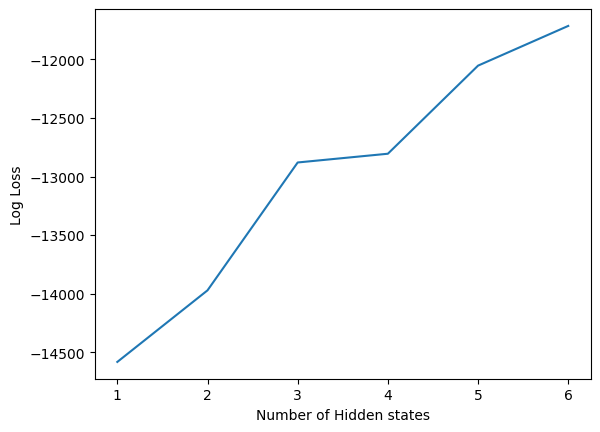

In [187]:
plt.plot(list(range(1,len(vals)+1)),vals)
plt.xlabel("Number of Hidden states")
plt.ylabel("Log Loss")
plt.show()
plt.close()

In [188]:
best_n, best_loss =max(enumerate(vals,1), key=lambda i: i[0])
print(f"Training with {best_n} hidden states")
model = CategoricalHMM(best_n, verbose=True, n_iter=1024)
model.fit(np.concatenate(encoded).reshape(-1, 1))


Training with 6 hidden states


         1 -834375.65907129             +nan
         2 -345172.35756597 +489203.30150532
         3 -339358.13520266   +5814.22236331
         4 -333350.48673909   +6007.64846357
         5 -326898.39111874   +6452.09562035
         6 -320298.26608706   +6600.12503168
         7 -313099.71600539   +7198.55008166
         8 -304096.98634596   +9002.72965943
         9 -296691.73175511   +7405.25459086
        10 -292681.04255724   +4010.68919787
        11 -290342.34655907   +2338.69599817
        12 -288647.93773951   +1694.40881956
        13 -287271.35929831   +1376.57844120
        14 -286208.41019743   +1062.94910089
        15 -285523.04147045    +685.36872698
        16 -285111.82482555    +411.21664489
        17 -284842.13890262    +269.68592293
        18 -284640.64622138    +201.49268124
        19 -284476.73359402    +163.91262737
        20 -284336.89855687    +139.83503715
        21 -284214.23272489    +122.66583198
        22 -284105.68991967    +108.54280523
        23

CategoricalHMM(n_components=6, n_features=391, n_iter=1024,
               random_state=RandomState(MT19937) at 0x7F8890782240,
               verbose=True)

In [ ]:
import pickle
with open("/content/markov1.pkl","wb") as outp:
  pickle.dump(model,outp)

In [189]:
def generate_molecules(min_heavy_atoms: int, max_heavy_atoms: int, num_mols: int, verbose: bool = True) -> List[rdkit.Chem.Mol]:
    pred_mols = []
    while len(pred_mols) < num_mols:
        sample, _ = model.sample(max_heavy_atoms)
        sample = sample.T[0]
        pred = enc.inverse_transform(sample)
        print(pred)
        try:
            mol = Chem.MolFromSmiles(pred)
        except:
            mol = None
        if mol and mol.GetNumAtoms() >= min_heavy_atoms:
            pred_mols.append(mol)
            if verbose:
                print(f"Found {len(pred_mols)} molecules. New molecule has weight {np.round(Chem.Descriptors.MolWt(mol), 3)} amu")

    return pred_mols



In [ ]:
# generated_mol = generate_molecules(min_heavy_atoms=5, max_heavy_atoms=30, num_mols=35, verbose=True)
# for mol in generated_mol:
#     Chem.Draw.MolToMPL(mol)
#     plt.show()
#     plt.close()

In [190]:
def load_model(file_path: str):
    with open(file_path, "rb") as inp:
        return pickle.load(inp)

# Load the model
pipeline = load_model("markov1.pkl")

In [191]:
from rdkit.Chem import Lipinski, Descriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem import Lipinski,Descriptors
import functools
def is_aromatic(smiles):
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    if molecule is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Check if the molecule is aromatic
    aromatic_atoms = [atom.GetIsAromatic() for atom in molecule.GetAtoms()]

    # If any atom in the molecule is aromatic, we consider the molecule aromatic
    return any(aromatic_atoms)
# def predict_bitter_from_smiles(smiles):
#     mol = Chem.MolFromSmiles(smiles)
#     if not mol:
#         return False  # Skip invalid molecules
#     descriptors = [
#         Lipinski.NumAromaticRings,
#         Lipinski.NumHAcceptors,
#         Lipinski.NumHDonors,
#         Descriptors.MolWt,
#         Descriptors.MinPartialCharge,
#         Descriptors.MaxPartialCharge,
#         Descriptors.FpDensityMorgan1,
#         Descriptors.FpDensityMorgan2,
#         Descriptors.FpDensityMorgan3,
#     ]
#     features = [descriptor(mol) for descriptor in descriptors]
#     result = model.predict([features])
#     return result[0]  # Assuming the model returns a list-like object and we need the first element




In [192]:
bitter_candidates = []
n_desired_candidates = 4

while len(bitter_candidates) < n_desired_candidates:
    generated_molecules = generate_molecules(min_heavy_atoms=2, max_heavy_atoms=15, num_mols=5, verbose=False)
    smiles_list = [Chem.MolToSmiles(mol) for mol in generated_molecules if mol is not None]  # Ensure valid SMILES
    bitter_candidates += list(filter(is_aromatic, smiles_list))
    print(f"Found {len(bitter_candidates)} aromatic molecules")


Streaming output truncated to the last 5000 lines.
CO)OO(C(I)O)(
NC(CI)[C@@H]cc1c
CC
OC
C[C@@H][K+]Cccccs(c2
C=N)P)CC==[C@@H])
CCICl
CCC
OC(CO(=I)O(=O
C=C([N+])F)C)Cl
(Cl)=O3cnc1CC=
CCnccc1(NC)O1
/O(O1=O)CC([C@@H]
CCOC)C)O3CCN)
CC)c1CCCc(O
CC1FC=F(C1
COC)CC)C)NC#S
=O)=O1(CC)C)C
[Zn+2]C
Found 2 aromatic molecules
CN(Cl)N
C
C([O-])ClSCl)C([C@@H])
OO(/[O-])CC)O1)c
NO)C[C@@H](N(ccc1
CCO2[C@])C(OCCC(
CCF12
CCC
OCO1OO(ccc1cc
OCC(C1C)OCcnc
(C)OO(O)CO2[C@H](
=[C@H](/O)CN(=[C@@]C

CC)C(NC(CO4CC
CCCCC=C)C)CN(
Cc2c)Cc2c1nc1
CCC=CN(CC=[C@H]c
CFCC(=[C@@H]2cccs2
=NC(OC)Cccc2c

C=O)c1C=O)C(C
CC[C@H])O(cc)c)C4
=OCC
=C)[C@H](C)OOS(C[O-]
=C([C@H]CC/O(C([C@]1
C[C@H])CNcc2Sc
=[C@H]11c11[C@@H]1CC
COOc1c3[C@H](O)C)

(OCSC=c4CC/=
CN[C@@]2N=O)Ccc1c
c2ccc2
[Mg+2]=CC2
OC1[C@@H]1c2)Ccc)O
CCCO=[C@H](CO(C(c
CO)O2c)oc3)[C@H]
CNC)c2(NS)[C@H])N
1
C=O1c1c6CNC)
c1[nH]2O
O==O1CC=CN(
CC[C@@H]2OO(c1CCC
CO1c)N[C@H](C)F)N
INBr1OC)C=c1c
C
CCC)C=[C@H][nH]-1)[C@])
OC)NC)[C@H])NO)C2
=OIOCCC[C@H](
CO4c2ccc1N
N(cccc1cc1C
CC(cc)cc

In [193]:
print(bitter_candidates)

['OCCc1cccnc1', 'c1ccccc1', 'Cc1ccncc1', 'CCCOc1cccnc1N']


In [194]:
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
def plot_smiles(smiles):
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)

    if molecule is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Generate a 2D depiction of the molecule
    molecule_image = Draw.MolToImage(molecule)

    # Plot the image using matplotlib
    plt.imshow(molecule_image)
    plt.axis('off')  # Turn off axis
    plt.show()

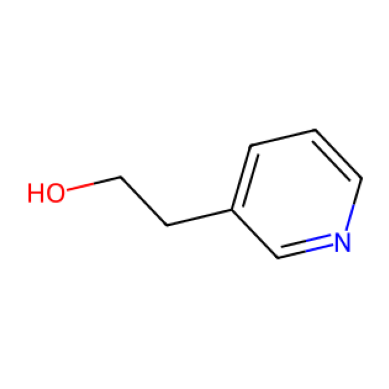

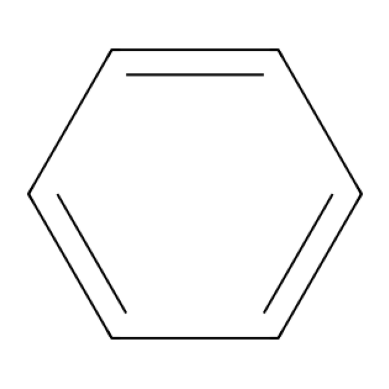

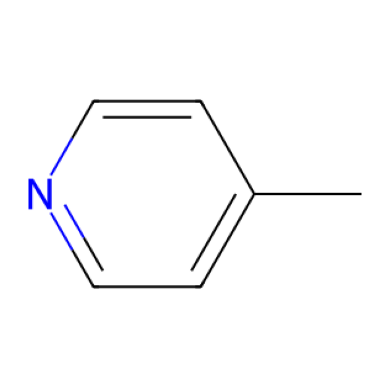

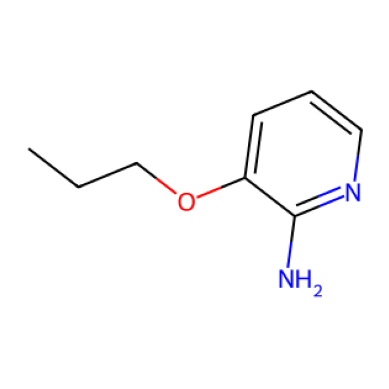

In [195]:

for mol in bitter_candidates:
    plot_smiles(mol)